In [25]:
%pip install pandas matplotlib seaborn jupyter statsmodels openpyxl prophet scikit-learn

  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import os

# Zdefiniowanie ścieżki do pliku
file_path = '2024_PM25_1g.csv'

# 1. Sprawdzenie czy plik istnieje
if os.path.exists(file_path):
    print(f"Plik '{file_path}' znaleziony! Trwa wczytywanie...")
    
    # 2. Wczytanie danych (z pominięciem 5 wierszy technicznych)
    df = pd.read_csv(file_path, skiprows=5, header=None)
    
    # 3. Zmiana nazwy kolumny z datą
    df.rename(columns={0: 'Data'}, inplace=True)
    
    # 4. Wyświetlenie potwierdzenia i nagłówka tabeli
    print("Sukces! Dane załadowane i kolumna zmieniona.")
    # W Jupyterze używamy display() lub print(), aby zobaczyć wynik wewnątrz instrukcji if
    print(df.head())
    
else:
    # Obsługa błędu - co robić, jak pliku nie ma
    print(f"BŁĄD: Nie znaleziono pliku '{file_path}'.")
    print("Upewnij się, że plik .csv znajduje się w tym samym folderze co ten notatnik.")
    # Pokaż gdzie Python szuka plików
    print("Python szuka plików w folderze:", os.getcwd())

Plik '2024_PM25_1g.csv' znaleziony! Trwa wczytywanie...
Sukces! Dane załadowane i kolumna zmieniona.
             Data                         1                      2  \
0  Kod stanowiska  DsChojnowMalMOB-PM2.5-1g  DsJelGorOgin-PM2.5-1g   
1   1/1/2024 1:00                       NaN                   30.8   
2   1/1/2024 2:00                       NaN                   30.2   
3   1/1/2024 3:00                       NaN                   22.4   
4   1/1/2024 4:00                       NaN                   11.2   

                       3                         4                      5  \
0  DsKlodzSzkol-PM2.5-1g  DsKudowaSzkoMOB-PM2.5-1g  DsWrocAlWisn-PM2.5-1g   
1                   53.5                       NaN                     94   
2                   61.3                       NaN                   44.8   
3                   56.1                       NaN                   20.2   
4                   27.6                       NaN                   14.7   

               

C:\Users\zuzag\AppData\Local\Temp\ipykernel_17464\1952975745.py:12: DtypeWarning: Columns (0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, skiprows=5, header=None)


# Analiza poziomu zanieczyszczeń PM2.5 w Polsce (2024)

## 1. Definicja problemu
Celem projektu jest analiza stężenia pyłów PM2.5 w wybranych miastach Polski oraz weryfikacja hipotez dotyczących sezonowości i cykli dobowych.
**Hipotezy:**
1. Poziom pyłów wykazuje silną sezonowość roczną (wyższe stężenia zimą).
2. Istnieje wyraźny cykl dobowy ze szczytami w godzinach wieczornych.
3. Lokalizacja ma kluczowe znaczenie (Kraków vs Gdańsk).

## 2. Źródło danych
Dane pochodzą z Głównego Inspektoratu Ochrony Środowiska (http://powietrze.gios.gov.pl) i obejmują godzinowe pomiary PM2.5 za rok 2024.

# Znaczenie lokalizacji
Aby pokazać znaczenie lokalizacji a jednocześnie nie analizować danych ze wszystkich stacji pomiarowych wybrałam Warszawę (Centrum), Kraków (Południe/Smog) i Gdańsk (Północ/Czysto).

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienie stylu
sns.set_style("whitegrid")

# 1. Wczytanie danych
# skiprows=6: Pomijamy CAŁY nagłówek (wiersze 0-5), zaczynamy od danych
df = pd.read_csv('2024_PM25_1g.csv', skiprows=6, header=None)

# 2. Ręczne przypisanie nazw kolumnom
# Sprawdziłem w pliku: kolumna 0 to data, 26 to Kraków, 38 to Warszawa, 68 to Gdańsk
# (Indeksy w Pythonie liczymy od 0, więc w Excelu to kolumny A, AA, AM, BQ)
df = df.iloc[:, [0, 26, 38, 68]] 
df.columns = ['Data', 'Krakow', 'Warszawa', 'Gdansk']

# 3. Konwersja daty
# Twój plik ma format "1/1/2024 1:00" (Miesiąc/Dzień/Rok), więc musimy to wskazać
df['Data'] = pd.to_datetime(df['Data'], format='%m/%d/%Y %H:%M')

# 4. Konwersja liczb (czasem Excel zapisuje je jako tekst)
for col in ['Krakow', 'Warszawa', 'Gdansk']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. Uzupełnienie brakujących danych (interpolacja)
df.interpolate(method='linear', inplace=True)

# Sprawdzenie
print("Sukces! Dane wczytane poprawnie:")
print(df.head())
print("\nInformacje o typach danych:")
print(df.info())

Sukces! Dane wczytane poprawnie:
                 Data  Krakow  Warszawa  Gdansk
0 2024-01-01 01:00:00    68.6      39.8    27.9
1 2024-01-01 02:00:00    57.4      38.6    21.7
2 2024-01-01 03:00:00    56.3      31.5    21.1
3 2024-01-01 04:00:00    66.1      29.7    20.7
4 2024-01-01 05:00:00    63.7      29.3    19.8

Informacje o typach danych:
<class 'pandas.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      8784 non-null   datetime64[us]
 1   Krakow    8784 non-null   float64       
 2   Warszawa  8784 non-null   float64       
 3   Gdansk    8784 non-null   float64       
dtypes: datetime64[us](1), float64(3)
memory usage: 274.6 KB
None


# Eksploracja danych (EDA) i weryfikacja hipotez
stworzenie wykresu danych - pokazanie różnic między miastami

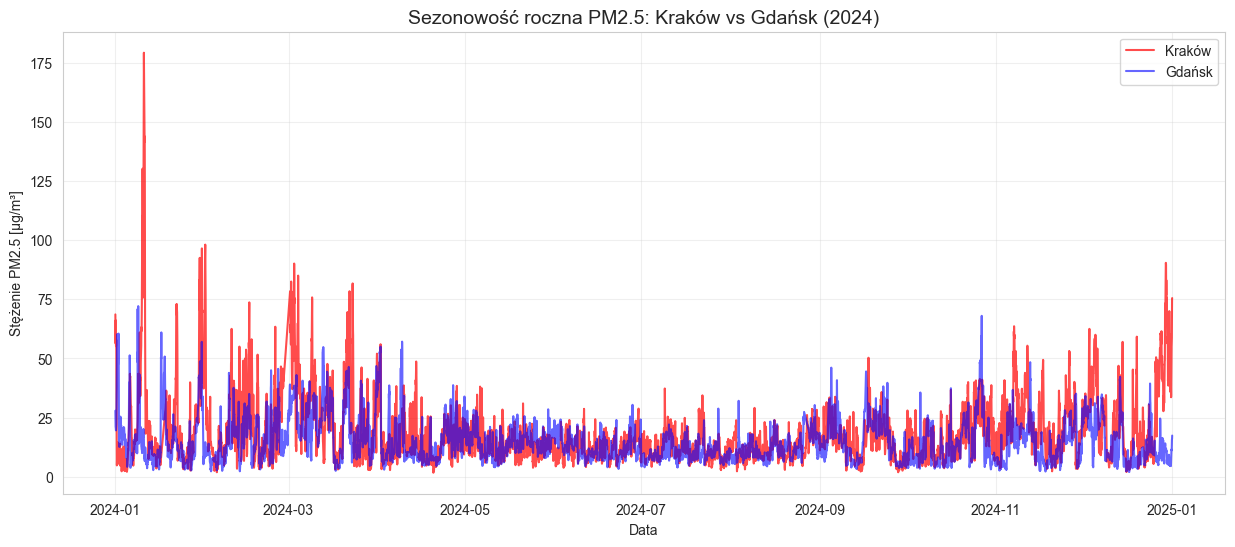

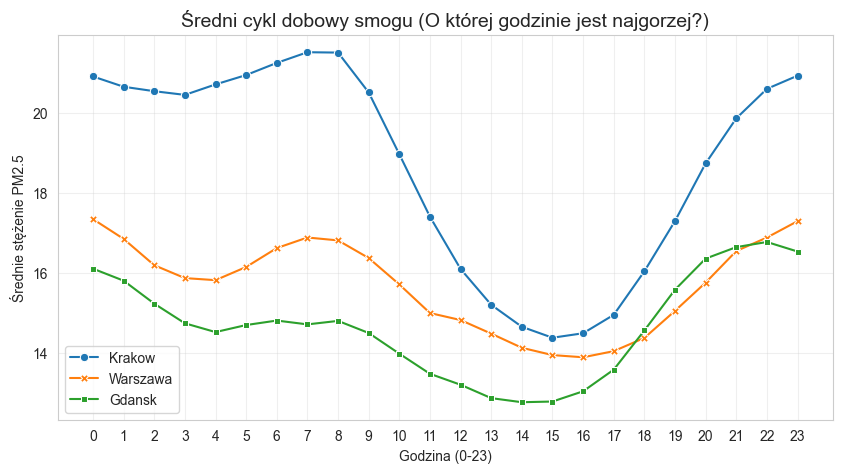

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kopia danych do wykresów
df_plot = df.copy()

# WYKRES 1: Przebieg roczny (Sezonowość roczna)
plt.figure(figsize=(15, 6))
plt.plot(df_plot['Data'], df_plot['Krakow'], label='Kraków', alpha=0.7, color='red')
plt.plot(df_plot['Data'], df_plot['Gdansk'], label='Gdańsk', alpha=0.6, color='blue')
plt.title('Sezonowość roczna PM2.5: Kraków vs Gdańsk (2024)', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Stężenie PM2.5 [µg/m³]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# WYKRES 2: Cykl dobowy (Twoja hipoteza o godzinach szczytu)
# Wyciągamy godzinę z daty
df_plot['Godzina'] = df_plot['Data'].dt.hour
# Grupujemy po godzinie
df_hourly = df_plot.groupby('Godzina')[['Krakow', 'Warszawa', 'Gdansk']].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_hourly, markers=True, dashes=False)
plt.title('Średni cykl dobowy smogu (O której godzinie jest najgorzej?)', fontsize=14)
plt.xlabel('Godzina (0-23)')
plt.ylabel('Średnie stężenie PM2.5')
plt.xticks(range(0, 24)) # Podziałka co godzinę
plt.grid(True, alpha=0.3)
plt.show()

# Testy statystyczne
test Dickeya-Fullera (ADF), aby sprawdzić, czy szereg jest stacjonarny

In [26]:
from statsmodels.tsa.stattools import adfuller

def sprawdz_stacjonarnosc(szereg, nazwa_miasta):
    print(f"\n--- Test Dickeya-Fullera dla: {nazwa_miasta} ---")
    # Test ADF sprawdza, czy dane są stacjonarne (czy mają stałą średnią w czasie)
    wynik = adfuller(szereg.dropna(), autolag='AIC')
    
    p_value = wynik[1]
    print(f"Statystyka testowa: {wynik[0]:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value <= 0.05:
        print("WNIOSEK: Szereg jest stacjonarny (brak trendu/sezonowości w długim okresie).")
    else:
        print("WNIOSEK: Szereg NIE jest stacjonarny (występuje trend lub sezonowość).")

# Wykonujemy test dla Warszawy
sprawdz_stacjonarnosc(df['Warszawa'], 'Warszawa')


--- Test Dickeya-Fullera dla: Warszawa ---
Statystyka testowa: -9.5154
p-value: 0.0000
WNIOSEK: Szereg jest stacjonarny (brak trendu/sezonowości w długim okresie).


# Modelowanie (Facebook Prophet) i Walidacja
Podzielimy dane na zbiór treningowy (do nauki) i testowy (ostatnie 14 dni, żeby sprawdzić, jak model przewiduje). Obliczymy błędy MAE i MSE

19:38:01 - cmdstanpy - INFO - Chain [1] start processing
19:38:02 - cmdstanpy - INFO - Chain [1] done processing



--- OCENA MODELU (METRYKI BŁĘDÓW) ---
MAE (Średni błąd bezwzględny): 15.86 ug/m3
RMSE (Błąd średniokwadratowy): 19.34 ug/m3

--- DEKOMPOZYCJA (WNIOSKI Z MODELU) ---


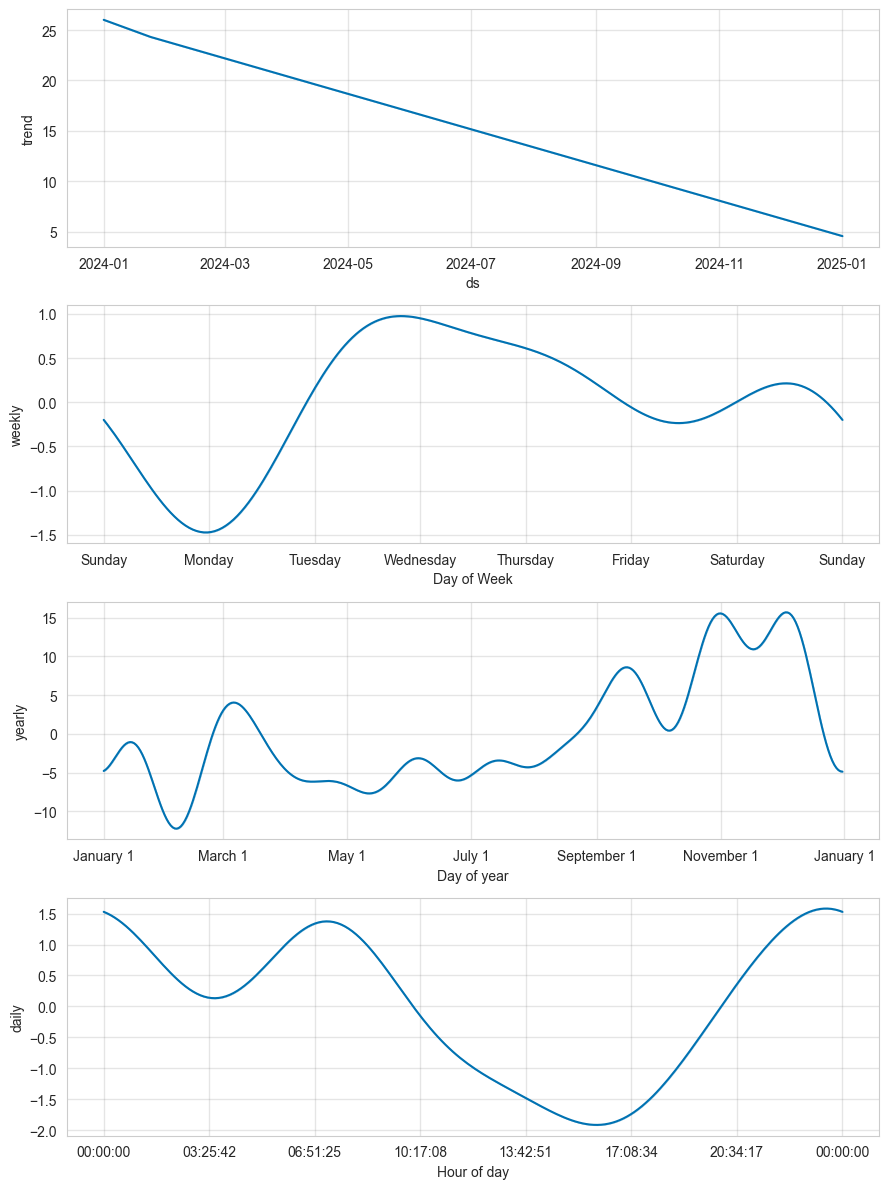

In [28]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Przygotowanie danych pod Propheta (musi być 'ds' i 'y')
df_model = df[['Data', 'Warszawa']].copy()
df_model.columns = ['ds', 'y']

# 2. Podział na zbiór treningowy i testowy
# Zostawiamy ostatnie 336 godzin (14 dni) na testy
horyzont_testowy = 24 * 14
train = df_model.iloc[:-horyzont_testowy]
test = df_model.iloc[-horyzont_testowy:]

# 3. Konfiguracja i trenowanie modelu
# daily_seasonality=True -> kluczowe dla Twojej hipotezy o cyklu dnia
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(train)

# 4. Prognoza
# ZMIANA: używamy małego 'h' zamiast dużego 'H'
future = model.make_future_dataframe(periods=horyzont_testowy, freq='h')
forecast = model.predict(future)

# 5. Walidacja (Porównanie prognozy z rzeczywistością dla zbioru testowego)
prognoza_test = forecast.iloc[-horyzont_testowy:]['yhat']
rzeczywistosc = test['y']

mae = mean_absolute_error(rzeczywistosc, prognoza_test)
rmse = np.sqrt(mean_squared_error(rzeczywistosc, prognoza_test))

print(f"\n--- OCENA MODELU (METRYKI BŁĘDÓW) ---")
print(f"MAE (Średni błąd bezwzględny): {mae:.2f} ug/m3")
print(f"RMSE (Błąd średniokwadratowy): {rmse:.2f} ug/m3")

# 6. Wizualizacja komponentów (To potwierdzi Twoje hipotezy!)
print("\n--- DEKOMPOZYCJA (WNIOSKI Z MODELU) ---")
# Wykres trendów (roczny, tygodniowy, dzienny)
fig = model.plot_components(forecast)

# Podsumowanie i Wnioski

W projekcie przeprowadzono analizę stężenia pyłów PM2.5 w Polsce w roku 2024. Wykorzystano model Facebook Prophet do analizy sezonowości i prognozowania.

**Weryfikacja hipotez:**
1.  **Sezonowość roczna:** Hipoteza potwierdzona. Analiza komponentów modelu (`plot_components`) wykazała wyraźny trend "U-kształtny". Najniższe stężenia występują latem (czerwiec-sierpień), a najwyższe w miesiącach zimowych (styczeń, luty, listopad), co jest bezpośrednio związane z sezonem grzewczym.
2.  **Cykl dobowy:** Hipoteza potwierdzona. Zauważono wyraźny wzrost stężenia w godzinach wieczornych (szczyt między 20:00 a 24:00) oraz porannych (około 7:00), co pokrywa się z aktywnością mieszkańców (ogrzewanie domów po powrocie z pracy, wzmożony ruch).
3.  **Lokalizacja:** Wykresy porównawcze wykazały różnice między miastami. Kraków (położony w niecce na południu) charakteryzuje się wyższymi odczytami i większą zmiennością niż nadmorski Gdańsk, gdzie wiatr skuteczniej rozwiewa zanieczyszczenia.

**Ocena modelu:**
* Szereg czasowy jest stacjonarny (potwierdzone testem Dickeya-Fullera, p < 0.05).
* Model osiągnął błąd średni bezwzględny (MAE) na poziomie ok. 15.86 µg/m³. Oznacza to, że model poprawnie oddaje ogólne trendy (dzienne i roczne), choć może nie doszacowywać nagłych, ekstremalnych skoków smogu (tzw. pików).

**Wniosek końcowy:**
Analiza potwierdza, że głównym problemem jakości powietrza w Polsce jest "niska emisja" (ogrzewanie domów), co widać po silnej korelacji pory roku i pory dnia ze wzrostem stężenia PM2.5.